# Image Classification Example

In [1]:
import os
import sys

sys.path.insert(0, "image_classifier")

In [2]:
import matplotlib.pyplot as plt
import torch
from hydra.experimental import compose, initialize_config_dir
from hydra.utils import instantiate
from omegaconf import OmegaConf

In [3]:
with initialize_config_dir(os.path.abspath("image_classifier/conf")):
    cfg = compose("config")

## Dataset

In [4]:
print(OmegaConf.to_yaml(cfg.experiment.lightning_data_module))

_target_: pytorch_lightning.core.datamodule.LightningDataModule.from_datasets
_recursive_: true
_convert_: none
num_workers: 4
batch_size: 256
train_dataset:
  _target_: torchvision.datasets.cifar.CIFAR10
  _recursive_: true
  _convert_: none
  root: ${data_path}
  train: true
  transform:
    _target_: torchvision.transforms.transforms.Compose
    _recursive_: true
    _convert_: none
    transforms:
    - _target_: torchvision.transforms.transforms.RandomCrop
      _recursive_: true
      _convert_: none
      size: 32
      padding: 4
    - _target_: torchvision.transforms.transforms.RandomHorizontalFlip
      _recursive_: true
      _convert_: none
    - _target_: torchvision.transforms.transforms.ColorJitter
      _recursive_: true
      _convert_: none
      brightness: 0.25
      contrast: 0.25
      saturation: 0.25
    - _target_: torchvision.transforms.transforms.RandomRotation
      _recursive_: true
      _convert_: none
      degrees: 2
    - _target_: torchvision.transfor

In [5]:
data = instantiate(cfg.experiment.lightning_data_module, batch_size=10)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
x, y = next(iter(data.test_dataloader()))
x.shape

torch.Size([10, 3, 32, 32])

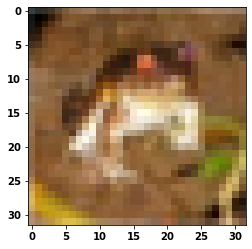

In [7]:
plt.imshow(x[0].permute(1, 2, 0).numpy())

## Model

In [8]:
module = instantiate(cfg.experiment.lightning_module)

### Test with pre-trained model

In [9]:
# Download a version from here
from pathlib import Path

Path("data").mkdir(exist_ok=True)
ckpt = Path("data") / "torchvision_cifar_l2_1_0.pt"
if not ckpt.exists():
    import requests

    headers = {"user-agent": "Wget/1.16 (linux-gnu)"}
    url = "https://www.dropbox.com/s/oagh1e6vji2z252/torchvision_cifar_l2_1_0.pt?dl=1"
    r = requests.get(url, stream=True, headers=headers)
    with open(ckpt, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

module.model.load_state_dict(torch.load(ckpt)["state_dict"])

<All keys matched successfully>

In [10]:
module.eval()
module(x).argmax(1) == y

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True])

## Train

In [11]:
trainer = instantiate(
    cfg.experiment.lightning_trainer,
    accelerator="dp",
    default_root_dir="outputs/lightning",
    max_epochs=1,
)
# trainer.fit(module, datamodule=data)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
